# Importing framworks

In [24]:
import torch
from torch import nn
from torchvision.transforms import v2

import numpy as np
import pandas as pd

from PIL import Image

import pathlib as pl
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

# Creating the datasets

In [25]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        
        labels = self.labels[idx]
        return image, labels


## Rahman dataset

In [26]:

class RahmanDataset:
    def __init__(self, path, train_size=0.8, k_folds=5, train_transform=None, test_transform=None):
        self.path = path
        self.k_folds = k_folds
        self.train_size = train_size
        self.train_transform = train_transform if train_transform is not None else v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
        self.test_transform = test_transform if train_transform is not None else v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
        self.labels_names = {0: 'noncarcinoma', 1: 'carcinoma'}
        self.train, self.test = self._train_test_split()

        self.train_dataset = CustomDataset(self.train[0], self.train[1], transform=self.train_transform)
        self.test_dataset = CustomDataset(self.test[0], self.test[1], transform=self.test_transform)

        self.k_folds_dataset = self._generate_k_folds()
        self.folds_df = None

    
    def _get_files(self):
        """
        Get files from the path by class carcinoma and non-carcinoma
        """
        # carcinoma images
        carcinoma = list(self.path.glob("First Set/100x OSCC Histopathological Images/*.jpg"))
        carcinoma.extend(list(self.path.glob('Second Set/400x OSCC Histopathological Images/*.jpg')))
        
        # non-carcinoma images
        noncarcinoma = list(self.path.glob('First Set/100x Normal Oral Cavity Histopathological Images/*.jpg'))
        noncarcinoma.extend(list(self.path.glob('Second Set/400x Normal Oral Cavity Histopathological Images/*.jpg')))

        return carcinoma, noncarcinoma

    def _train_test_split(self):
        """
        Split the dataset into train and test
        """
        # get file complete path for each image file 
        carcinoma, noncarcinoma = self._get_files()

        # create arrays of 1 and 0 for carcinoma and non-carcinoma
        carcinoma_labels = list(np.ones(len(carcinoma)))
        noncarcinoma_labels = list(np.zeros(len(noncarcinoma)))

        # extend the labels
        labels = carcinoma_labels + noncarcinoma_labels
        images = carcinoma + noncarcinoma

        # split the dataset by parent name
        images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size=self.train_size, stratify=labels, random_state=42)

        return (images_train, labels_train), (images_test, labels_test)

    def _create_df_splits(self, k_folds_datasets):
        """
        Create dataframe with the k-folds splits for the dataset
        """
        folds = [(i, fold) for i, fold in enumerate(k_folds_datasets)]
        folds = [(fold[0], fold[1][2], fold[1][3]) for fold in folds]

        # expand the folds
        folds = [(fold[0], image.parts[-1], label) for fold in folds for image, label in zip(fold[1], fold[2])]

        self.folds_df = pd.DataFrame(folds, columns=['fold', 'image_path', 'class'])

    def _generate_k_folds(self):
        """
        Generate k-folds for the dataset
        """
        
        images, labels = self.train
        images = self.train[0]

        folds = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        folds_list = []

        for j, fold in enumerate(folds.split(images, labels)):
            train_index, test_index = fold

            train_imgs = [images[i] for i in train_index]
            test_imgs = [images[i] for i in test_index]

            train_labels = [labels[i] for i in train_index]
            test_labels = [labels[i] for i in test_index]

            folds_list.append((train_imgs, train_labels, test_imgs, test_labels))

        self._create_df_splits(folds_list)

        return folds_list
    
    def get_k_fold_train_val_tuple(self, k):
        """
        Get K-fold train and validation dataset
        """
        train_dataset = CustomDataset(self.k_folds_dataset[k][0], self.k_folds_dataset[k][1], transform=self.train_transform)
        val_dataset = CustomDataset(self.k_folds_dataset[k][2], self.k_folds_dataset[k][3], transform=self.test_transform)

        return train_dataset, val_dataset


    def __len__(self):
        return len(self.train[0]) + len(self.test[0])

### Loading database

In [27]:
RAHMAN_PATH = pl.Path(os.path.abspath("")) / pl.Path('../data') / pl.Path('Histopathological imaging database for Oral Cancer analysis')

#Uncomment this to check if the root folder exists
print(f'RAHMAN_PATH.exists(): {RAHMAN_PATH.exists()}')

rahman_dataset = RahmanDataset(RAHMAN_PATH) 


RAHMAN_PATH.exists(): True


### Cheking if the split was done correctly

In [28]:
print(np.unique(rahman_dataset.test[1], return_counts=True))
print(np.unique(rahman_dataset.train[1], return_counts=True))

print(f'Split %: {len(rahman_dataset.train[0])/(len(rahman_dataset.test[0])+len(rahman_dataset.train[0]))}%') if len(rahman_dataset.train[0]) else print("Zero lenght test split")

(array([0., 1.]), array([ 58, 187]))
(array([0., 1.]), array([232, 747]))
Split %: 0.7998366013071896%


In [29]:
train_images = set(rahman_dataset.train[0])
test_images = set(rahman_dataset.test[0])

### Checking for duplicates

In [30]:
len(train_images.intersection(test_images))


0

In [31]:
len(rahman_dataset)

1224

In [32]:
len(rahman_dataset.train[0])

979

In [33]:
len(rahman_dataset.test[0])

245

In [34]:
train_images = set(rahman_dataset.train[0])
test_images = set(rahman_dataset.test[0])

In [35]:
len(train_images.intersection(test_images))

0

In [36]:
train_images.intersection(test_images)

set()

In [37]:
len(train_images)

979

In [38]:
len(test_images)

245

### Checking the dataloader

In [39]:
rahman_dataset.train_dataset[0]

(Image([[[0.8902, 0.8784, 0.8784,  ..., 0.8392, 0.7922, 0.7765],
         [0.9098, 0.8941, 0.8902,  ..., 0.8275, 0.8275, 0.8235],
         [0.9216, 0.9137, 0.8941,  ..., 0.8275, 0.8588, 0.8627],
         ...,
         [0.3686, 0.3843, 0.4118,  ..., 0.3569, 0.3961, 0.4078],
         [0.3765, 0.3725, 0.3882,  ..., 0.3569, 0.4078, 0.4235],
         [0.3294, 0.3490, 0.3882,  ..., 0.3608, 0.4118, 0.4314]],
 
        [[0.8902, 0.8902, 0.8902,  ..., 0.8667, 0.8431, 0.8392],
         [0.9098, 0.9059, 0.9020,  ..., 0.8549, 0.8627, 0.8706],
         [0.9294, 0.9216, 0.9059,  ..., 0.8510, 0.8706, 0.8706],
         ...,
         [0.3529, 0.3686, 0.4000,  ..., 0.3059, 0.3098, 0.3059],
         [0.3333, 0.3373, 0.3608,  ..., 0.2941, 0.2980, 0.2941],
         [0.2784, 0.3059, 0.3490,  ..., 0.2902, 0.2941, 0.2824]],
 
        [[0.7804, 0.7686, 0.7686,  ..., 0.7059, 0.6627, 0.6471],
         [0.8078, 0.8000, 0.7804,  ..., 0.6941, 0.6863, 0.6824],
         [0.8471, 0.8353, 0.8000,  ..., 0.7020, 0.7020, 

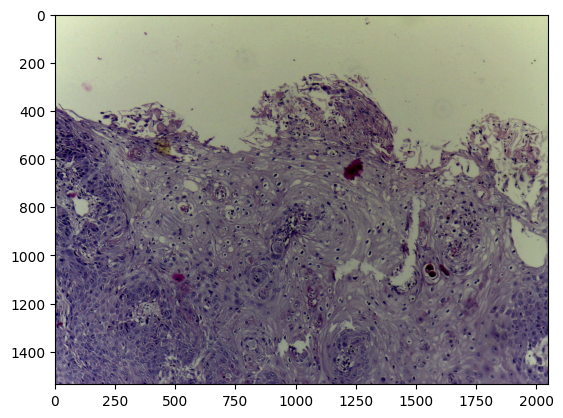

In [40]:
plt.imshow(rahman_dataset.train_dataset[0][0].permute(1, 2, 0))

### Checking if the folds are stratified

In [41]:
print(f'Folds lengths, {rahman_dataset.k_folds} folds')
for i in range(rahman_dataset.k_folds):
    print(f"Fold {i}: train {len(rahman_dataset._generate_k_folds()[i][0])}, test {len(rahman_dataset._generate_k_folds()[i][2])}")
    
    # get the labels count
    train_labels = np.unique(rahman_dataset._generate_k_folds()[i][1], return_counts=True)
    test_labels = np.unique(rahman_dataset._generate_k_folds()[i][3], return_counts=True)
    print(f"Train labels: {train_labels[0]}, {train_labels[1] / len(rahman_dataset._generate_k_folds()[i][1]) * 100}%")
    print(f"Test labels: {test_labels[0]}, {test_labels[1] / len(rahman_dataset._generate_k_folds()[i][1]) * 100}%\n")

mean = np.mean([len(rahman_dataset._generate_k_folds()[i][0]) for i in range(5)])
print(f"Mean train length: {mean}")

std = np.std([len(rahman_dataset._generate_k_folds()[i][0]) for i in range(5)])
print(f"Std train length: {std}")

Folds lengths, 5 folds
Fold 0: train 783, test 196
Train labels: [0. 1.], [23.75478927 76.24521073]%
Test labels: [0. 1.], [ 5.87484036 19.15708812]%

Fold 1: train 783, test 196
Train labels: [0. 1.], [23.75478927 76.24521073]%
Test labels: [0. 1.], [ 5.87484036 19.15708812]%

Fold 2: train 783, test 196
Train labels: [0. 1.], [23.62707535 76.37292465]%
Test labels: [0. 1.], [ 6.00255428 19.0293742 ]%

Fold 3: train 783, test 196
Train labels: [0. 1.], [23.62707535 76.37292465]%
Test labels: [0. 1.], [ 6.00255428 19.0293742 ]%

Fold 4: train 784, test 195
Train labels: [0. 1.], [23.7244898 76.2755102]%
Test labels: [0. 1.], [ 5.86734694 19.00510204]%

Mean train length: 783.2
Std train length: 0.4


### Checking k_folds dataloader

img: /home/rigor/Documentos/IAnaSaude/2024-2-P2-OSCC-domain-shift-classification/notebooks/../data/Histopathological imaging database for Oral Cancer analysis/First Set/100x OSCC Histopathological Images/OSCC_100x_169.jpg
label: 1.0


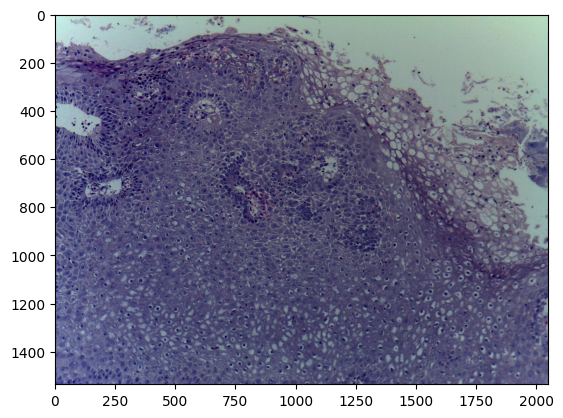

In [42]:
k = 1
img_index = 1
rahman_dataset_k_fold = rahman_dataset.get_k_fold_train_val_tuple(k)
rahman_dataset_k_fold_train = rahman_dataset_k_fold[0]
rahman_dataset_k_fold_train_images = rahman_dataset_k_fold_train[img_index]
rahman_dataset_k_fold_train_images_firstImg = rahman_dataset_k_fold_train_images[0]

print(f'img: {rahman_dataset._generate_k_folds()[k][0][img_index]}')
print(f'label: {rahman_dataset_k_fold_train_images[1]}')
__ = plt.imshow(rahman_dataset_k_fold_train_images_firstImg.permute(1, 2, 0))
